## Download and Visualize Data

In [ ]:
#!wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
#!mkdir emojis
#!unzip -q openmoji-72x72-color.zip -d ./emojis
#!pip install tensorflow==2.4

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

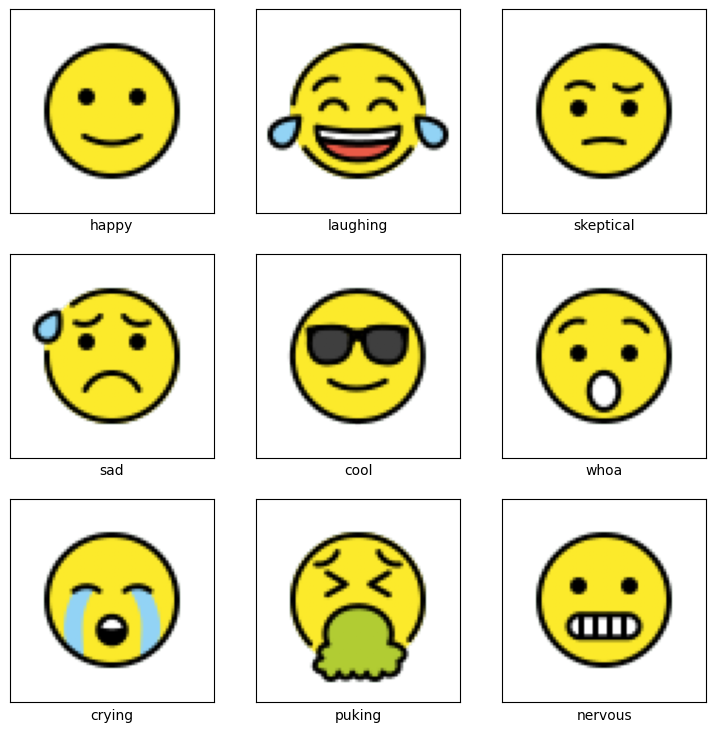

In [4]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create Examples

In [5]:
for class_id, values in emojis.items():
   png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
   png_file.load()
   new_file = Image.new("RGB", png_file.size, (255, 255, 255))
   new_file.paste(png_file, mask=png_file.split()[3])
   emojis[class_id]['image'] = new_file

In [6]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [ ]:
def create_example():
   class_id = np.random.randint(0, 9)
   image = np.ones((114, 114, 3))* 255
   row = np.random.randint(0, 72)
   col = np.random.randint(0, 72)
   image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
   return image.astype('uint8'), class_id, (row + 10)/144, (col + 10)/144

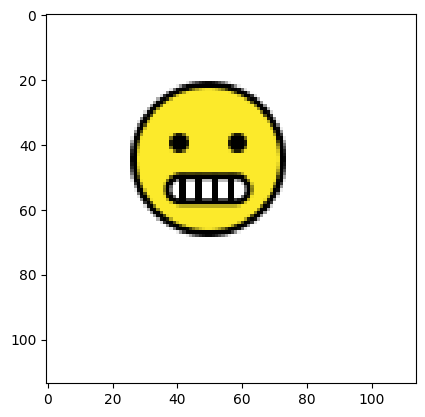

In [18]:
def create_example_safe():
	class_id = np.random.randint(0, 9)
	image = np.ones((114, 114, 3)) * 255
	row = np.random.randint(0, 114 - 72 + 1)
	col = np.random.randint(0, 114 - 72 + 1)
	image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
	return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

image, class_id, row, col = create_example_safe()
plt.imshow(image)

## Plot Bounding Boxes

In [19]:
def plot_bounding_box(image, gt_coords, pred_coords = None, norm = False):
	if norm:
		image *= 255
		image = image.astype('uint8')
	image = Image.fromarray(image)
	draw = ImageDraw.Draw(image)
   
	row,col = gt_coords
	row*= 144
	col*= 144
	draw.rectangle((col, row, col + 52, row + 52), outline = 'green', width = 3)

	if pred_coords:
		row, col = pred_coords
		row *= 144
		col *= 144
		draw.rectangle((col, row, col + 52, row + 52), outline = 'red', width = 3)
	return image   

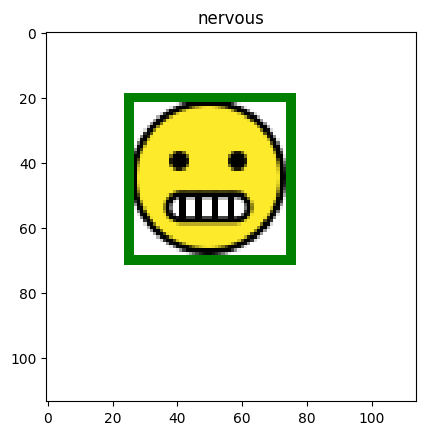

In [20]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.imshow(image)

## Data Generator

In [23]:
def data_generator(batch_size = 16):
	while True:
		x_batch = np.zeros((batch_size, 144, 144,3))
		y_batch = np.zeros((batch_size, 9))
		box_batch = np.zeros((batch_size, 2))
   
		for i in range(0, batch_size):
			image, class_id, row, col = create_example_safe()
			x_batch[i] = image/255 
			y_batch[i, class_id] = 1.0
			box_batch[i] = np.array([row, col])
		yield {'image': x_batch}, {'class_out': y_batch, 'box_out': box_batch} 

NameError: name 'example' is not defined

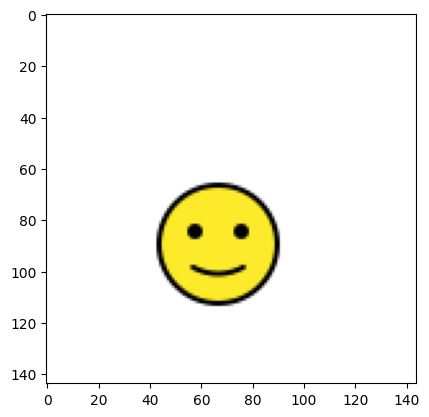

In [ ]:
def create_example_safe():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255
    row = np.random.randint(0, 144 - 72 + 1)
    col = np.random.randint(0, 144 - 72 + 1)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

image, class_id, row, col = create_example_safe()
plt.imshow(image)
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm = True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Task 6: Model

## Task 7: Custom Metric: IoU

## Task 8: Compile the Model

## Task 9: Custom Callback: Model Testing

## Task 10: Model Training